<a href="https://colab.research.google.com/github/kaleeswaranm/MaskTrack/blob/main/masktrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir data
!unzip /content/drive/MyDrive/stryker/DAVIS2017-master.zip -d /content/data

In [2]:
#for image processing
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A

#for working with paths
import glob
import os

#for array and numeric operations
import math
import numpy as np

#for model train test
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import *
import tensorflow as tf

#misc
from tqdm import tqdm
import random
import pandas as pd

In [3]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""

    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [4]:
def get_unet(input_size, n_filters = 32, dropout = 0.5, batchnorm = True, num_classes = 1):
    """Function to define the UNET Model"""

    inputs = Input(shape=input_size)
    c1 = conv2d_block(inputs, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [5]:
temp_image = '/content/data/DAVIS2017-master/Train_Annotated/bike-packing/00012.png'
img = cv2.imread(temp_image)[:,:,::-1]

In [6]:
def get_unique(img):
  a = np.copy(img)
  h, w, c = a.shape
  a = a.reshape((h * w, c))
  unique, counts = np.unique(a, return_counts=True, axis=0)
  return unique

unique = get_unique(img)

In [7]:
individual_masks = []
for unique_pixel in unique:
  if not (unique_pixel == np.array([0, 0, 0])).all():
    copy_image = img.copy()
    for i in range(copy_image.shape[0]):
      for j in range(copy_image.shape[1]):
        if (copy_image[i, j, :] == unique_pixel).all():
          copy_image[i, j, :] = np.array([0, 0, 0])
    individual_masks.append(copy_image)

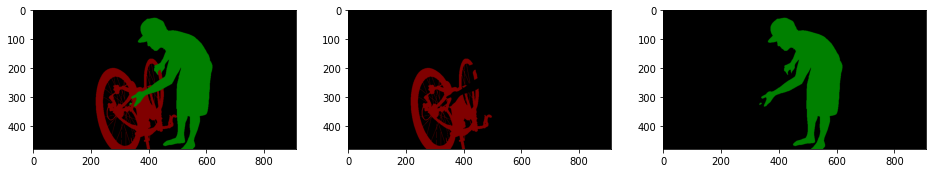

In [8]:
f, ax = plt.subplots(1, len(individual_masks) + 1, figsize=(16, 16))
ax[0].imshow(img)
for i in range(len(individual_masks)):
  ax[i + 1].imshow(individual_masks[i])

In [9]:
temp_mask = individual_masks[1]
copy_temp_mask = temp_mask.copy()
mask_unique = get_unique(copy_temp_mask)
mask_unique = [a for a in list(mask_unique) if not (a == np.array([0, 0, 0])).all()]

In [10]:
pos = np.where((copy_temp_mask == mask_unique).all(axis=-1))
start_index = (min(pos[1]), min(pos[0]))
end_index = (max(pos[1]), max(pos[0]))

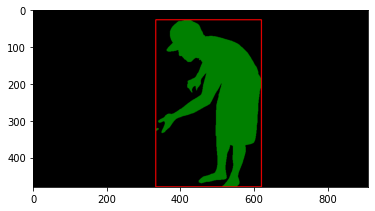

In [11]:
plt.imshow(cv2.rectangle(copy_temp_mask, start_index, end_index, (255, 0, 0), 2))

In [12]:
x_size = end_index[0] - start_index[0]
y_size = end_index[1] - start_index[1]

In [73]:
def horizontal_shift(img, x_size, y_size):
  rint = random.randint(0, 10)
  move_pixels = int(rint * 0.01 * x_size)
  num_rows, num_cols = img.shape[:2]
  l_or_r = random.randint(0, 1)
  if l_or_r == 0:
    translation_matrix = np.float32([[1,0,-1 * move_pixels], [0,1,0]])
  else:
    translation_matrix = np.float32([[1,0,move_pixels], [0,1,0]])
  aug_img = cv2.warpAffine(img, translation_matrix, (num_cols,num_rows))
  return aug_img

In [48]:
def thin_plate_splines(img):
  N=5
  points=[]
  dx=int(180/(N-1))
  for i in range(2*N):
      points.append((dx*i,4))
      points.append((dx*i,36))
  # Widen a circle around
  img = cv2.copyMakeBorder(img,4,4,0,0,cv2.BORDER_REPLICATE)

  tps = cv2.createThinPlateSplineShapeTransformer()

  sourceshape = np.array(points,np.int32)
  sourceshape=sourceshape.reshape(1,-1,2)
  matches =[]
  for i in range(1,N+1):
      matches.append(cv2.DMatch(i,i,0))

  # Start random changes
  newpoints=[]
  PADDINGSIZ=5
  for i in range(N):
      nx=points[i][0]+random.randint(0,PADDINGSIZ)-PADDINGSIZ/2
      ny=points[i][1]+random.randint(0,PADDINGSIZ)-PADDINGSIZ/2
      newpoints.append((nx,ny))
  #print(points,newpoints)
  targetshape = np.array(newpoints,np.int32)
  targetshape=targetshape.reshape(1,-1,2)
  tps.estimateTransformation(sourceshape,targetshape,matches)
  img=tps.warpImage(img)
  return img

In [81]:
def dilation(img):
  kernel = np.ones((5,5), np.uint8)
  aug_img = cv2.dilate(img, kernel, iterations=1)
  return aug_img

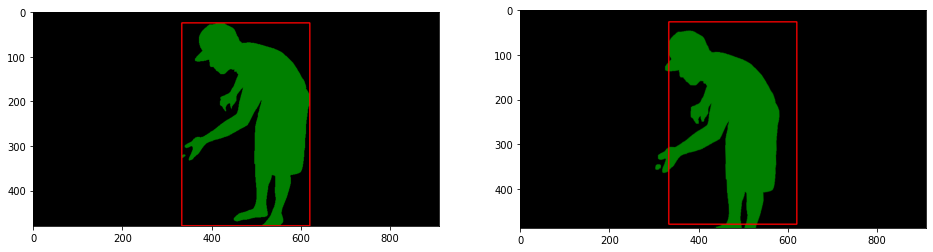

In [87]:
aug_mask = horizontal_shift(temp_mask, x_size, y_size)
aug_mask = thin_plate_splines(aug_mask)
aug_mask = dilation(aug_mask)
f, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(cv2.rectangle(temp_mask.copy(), start_index, end_index, (255, 0, 0), 2))
ax[1].imshow(cv2.rectangle(aug_mask.copy(), start_index, end_index, (255, 0, 0), 2))